In [ ]:
!pip install transformers datasets evaluate scikit-learn
!pip install torch

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
import torch
import evaluate
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
mrpc_dataset = load_dataset("glue", "mrpc")
training_losses = []
batches = []

print(mrpc_dataset)

tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-base-en")

def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True)

tokenized_dataset = mrpc_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(mrpc_dataset['train'][0])
print(tokenized_dataset['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}
{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0, 'input_ids': [101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
accuracy = evaluate.load('accuracy')

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
labels = ['not equivalent', 'equivalent']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in id2label.items()}

print('id2label:', id2label)
print('label2id:', label2id)

id2label: {0: 'not equivalent', 1: 'equivalent'}
label2id: {'not equivalent': 0, 'equivalent': 1}


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "nghuyong/ernie-2.0-base-en", num_labels=len(labels), id2label=id2label, label2id=label2id
)
model.to(device)

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ErnieForSequenceClassification(
  (ernie): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(4, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0-11): 12 x ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [ ]:
class CustomTrainer (Trainer):
  def _inner_training_loop(self, batch_size =None, args =None, resume_from_checkpoint =None, trial =None, ignore_keys_for_eval = None):
    number_of_epochs = args.num_train_epochs
    start = time.time()
    train_loss =[]
    train_acc =[]
    eval_acc =[]
    criterion = torch.nn.CrossEntropyLoss().to(device)
    self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
    train_dataloader = self.get_train_dataloader()
    eval_dataloader = self.get_eval_dataloader()
    max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
    total_steps = 0

    for epoch in range (number_of_epochs):
      train_loss_per_epoch = 0
      train_acc_per_epoch = 0
      with tqdm(train_dataloader, unit="batch") as training_epoch:
        training_epoch.set_description( f"Training Epoch{epoch}")
        for step, inputs in enumerate(training_epoch):
          total_steps += 1
          batches.append(total_steps)
          # Loop used from AI suggestion
          for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
              inputs[k] = v.to(device)
          labels = inputs['labels']

          # forward pass
          self.optimizer.zero_grad()
          output = self.model(**inputs)
          # get the loss
          loss = criterion(output['logits'], labels)
          train_loss_per_epoch += loss.item()
          training_losses.append(loss.item())
          # calculate gradients
          loss.backward()
          # update weights
          self.optimizer.step()
          train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
      # adjust the learning rate
      self.scheduler.step()
      train_loss_per_epoch /= len(train_dataloader)
      train_acc_per_epoch /= (len(train_dataloader)*batch_size)

      eval_loss_per_epoch = 0
      eval_acc_per_epoch = 0
      with tqdm(eval_dataloader, unit="batch") as eval_epoch:
        eval_epoch.set_description(f"Evaluation Epoch{epoch}")
        for step, inputs in enumerate(eval_epoch):
          # Loop used from AI suggestion
          for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
              inputs[k] = v.to(device)
          labels = inputs['labels']

          with torch.no_grad():
            output = self.model(**inputs)
            loss = criterion(output['logits'], labels)
            eval_loss_per_epoch += loss.item()
            eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()

      eval_loss_per_epoch /= (len(eval_dataloader))
      eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
      print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch * 100:.2f}%')
      print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch * 100:.2f}%')

    print(f'Time: {(time.time() - start)/60:.3f} minutes')

  # This function was completed using the help of ChatGPT
  def print_incorrect_predictions(self, eval_dataloader, original_dataset):
    self.model.eval()  # Set the model to evaluation mode
    incorrect_samples = []
    seen_indices = set()  # Set to keep track of already collected indices

    with torch.no_grad():
        for batch in eval_dataloader:
          # Loop used from AI suggestion
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
            labels = batch['labels']

            # Forward pass
            outputs = self.model(**batch)
            predictions = outputs['logits'].argmax(dim=1)

            # Apply softmax to logits to get confidence scores
            probabilities = torch.softmax(outputs['logits'], dim=1)

            # Collect incorrect samples
            incorrect = predictions != labels
            for i in range(len(incorrect)):
                if incorrect[i]:
                    # Check if the index has already been seen
                    if i in seen_indices:
                        continue
                    seen_indices.add(i)  # Add the index to the set

                    # Use the original dataset to get plain text
                    original_sample = original_dataset['validation'][i]
                    confidence_score = probabilities[i][predictions[i]].item()
                    sample = {
                        'sentence1': original_sample['sentence1'],
                        'sentence2': original_sample['sentence2'],
                        'predicted': predictions[i].item(),
                        'true': labels[i].item(),
                        'confidence': confidence_score
                    }
                    incorrect_samples.append(sample)

                # Number of samples is set at 10
                if len(incorrect_samples) >= 10:
                    break
            if len(incorrect_samples) >= 10:
                break

        # Print out the incorrect predictions and the confidence scores
        for i, sample in enumerate(incorrect_samples, 1):
            print(f"\nIncorrect Sample {i}:")
            print(f"Sentence 1: {sample['sentence1']}")
            print(f"Sentence 2: {sample['sentence2']}")
            print(f"Predicted Label: {sample['predicted']} (Confidence: {sample['confidence']:.4f})")
            print(f"True Label: {sample['true']}")

In [ ]:
training_args = TrainingArguments(
    output_dir='chill_model',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

eval_dataloader = trainer.get_eval_dataloader()
trainer.print_incorrect_predictions(eval_dataloader, mrpc_dataset)

trainer.train()


Incorrect Sample 1:
Sentence 1: The dollar was at 116.92 yen against the yen , flat on the session , and at 1.2891 against the Swiss franc , also flat .
Sentence 2: The dollar was at 116.78 yen JPY = , virtually flat on the session , and at 1.2871 against the Swiss franc CHF = , down 0.1 percent .
Predicted Label: 1 (Confidence: 0.5785)
True Label: 0

Incorrect Sample 2:
Sentence 1: No dates have been set for the civil or the criminal trial .
Sentence 2: No dates have been set for the criminal or civil cases , but Shanley has pleaded not guilty .
Predicted Label: 1 (Confidence: 0.5700)
True Label: 0

Incorrect Sample 3:
Sentence 1: While dioxin levels in the environment were up last year , they have dropped by 75 percent since the 1970s , said Caswell .
Sentence 2: The Institute said dioxin levels in the environment have fallen by as much as 76 percent since the 1970s .
Predicted Label: 1 (Confidence: 0.6613)
True Label: 0

Incorrect Sample 4:
Sentence 1: This integrates with Rational

Evaluation Epoch0: 100%|██████████| 13/13 [00:01<00:00,  7.76batch/s]

	Train Loss: 0.444 | Train Acc: 78.07%
	Eval Loss: 0.309 | Eval Acc: 86.78%
Time: 0.804 minutes


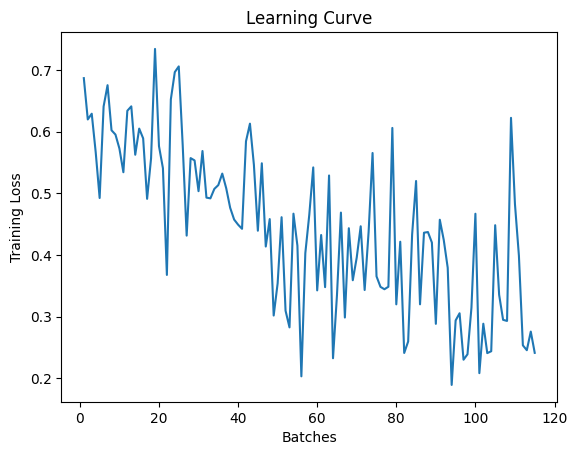

In [ ]:
plt.plot(batches, training_losses, label='Training Loss')
plt.xlabel("Batches")
plt.ylabel("Training Loss")
plt.title("Learning Curve")
plt.show()